In [1]:
!pip install transformers -q
!pip install sentencepiece -q

In [2]:
import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *
from plotting_helper import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'

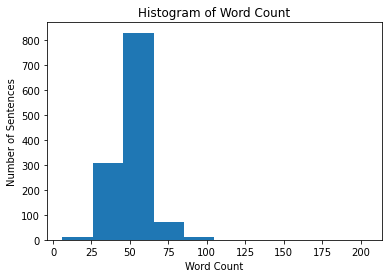

In [4]:
plot_histogram(data['Lyric'])

##### From the histogram, it is evident that most of the sentences have 50 words and some have 75. Although there are sentences with 100 words, the perecentage is very minimal. Hence maximum sequence length is considered as 75.

In [5]:
MAX_SEQ_LEN = 75
gpu, cpu = get_devices()

In [6]:
chk_point = 'ai4bharat/indic-bert'
base_model, tokenizer = load_bert_model(chk_point)

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=MAX_SEQ_LEN)

In [8]:
txt_only_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.TXT,
                                       k_folds=2, epochs=10, balance_classes=True, dropout_level=0.1, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Text Only Classification
FOLD 0
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 10
Training Model
Evaluating


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Losses - Train : 0.697 / Validation : 0.680
Time for epoch : 17.137118 seconds
Epoch 2 / 10
Training Model
Evaluating
Losses - Train : 0.688 / Validation : 0.660
Time for epoch : 17.115438 seconds
Epoch 3 / 10
Training Model
Evaluating
Losses - Train : 0.664 / Validation : 0.633
Time for epoch : 17.071404 seconds
Epoch 4 / 10
Training Model
Evaluating
Losses - Train : 0.638 / Validation : 0.612
Time for epoch : 17.343939 seconds
Epoch 5 / 10
Training Model
Evaluating
Losses - Train : 0.600 / Validation : 0.593
Time for epoch : 17.464025 seconds
Epoch 6 / 10
Training Model
Evaluating
Losses - Train : 0.520 / Validation : 0.583
Time for epoch : 17.246702 seconds
Epoch 7 / 10
Training Model
Evaluating
Losses - Train : 0.460 / Validation : 0.627
Time for epoch : 17.082042 seconds
Epoch 8 / 10
Training Model
Evaluating
Losses - Train : 0.390 / Validation : 0.880
Time for epoch : 16.927546 seconds
Epoch 9 / 10
Training Model
Evaluating
Losses - Train : 0.358 / Validation : 0.812
Time for epo

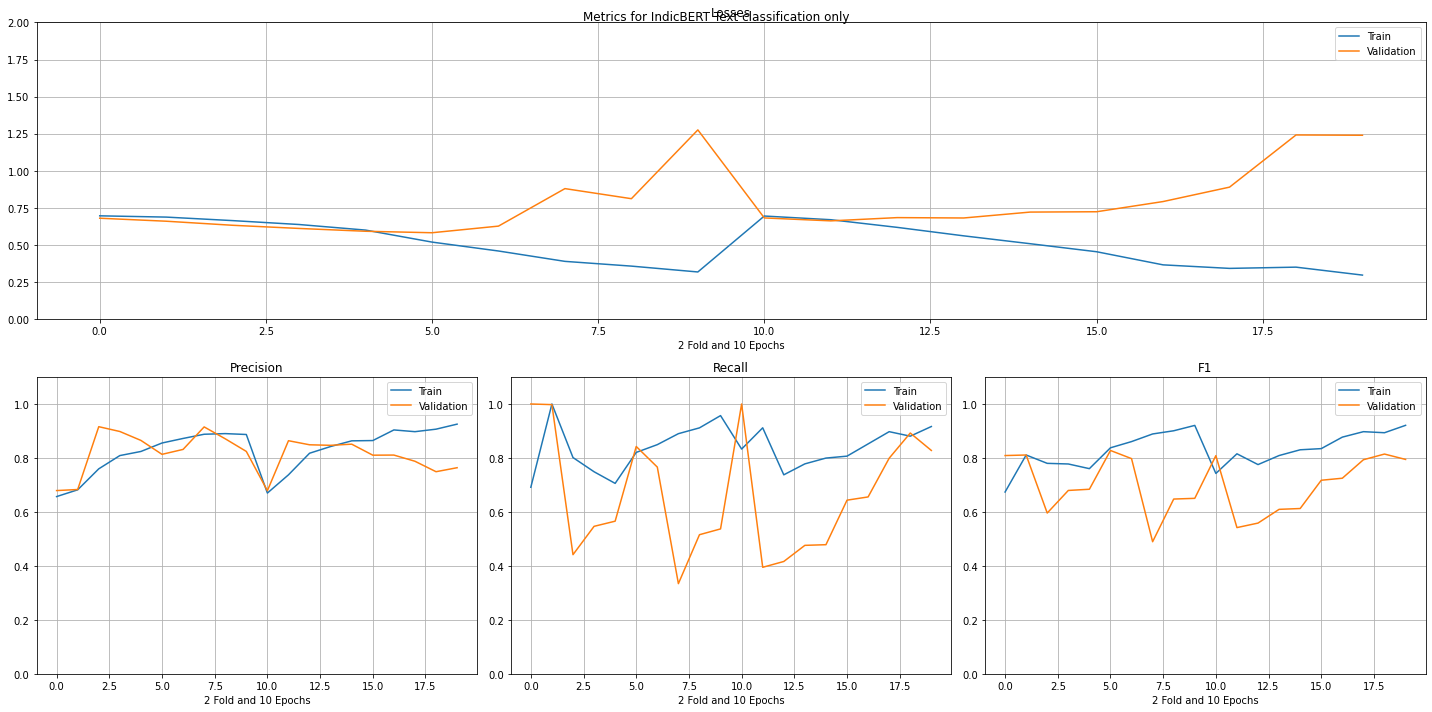

In [9]:
plot_results(txt_only_results[0], 'IndicBERT Text classification only')

In [10]:
txt_only_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_precision,train_recall,train_f1,validation_precision,validation_recall,validation_f1,train_losses,validation_losses
5,0.855362,0.820574,0.837607,0.813364,0.842482,0.827667,0.519588,0.582608
8,0.906634,0.880668,0.893462,0.748996,0.892344,0.814410,0.350764,1.241472
1,0.681892,1.000000,0.810863,0.683007,0.997613,0.810863,0.688035,0.660276
0,0.656818,0.691388,0.673660,0.679092,1.000000,0.808880,0.696591,0.680469
0,0.669866,0.832936,0.742553,0.678571,1.000000,0.808511,0.695222,0.682414
6,0.872236,0.849282,0.860606,0.831606,0.766110,0.797516,0.459573,0.627263
9,0.925301,0.916468,0.920863,0.763797,0.827751,0.794489,0.297164,1.239506
7,0.897375,0.897375,0.897375,0.787736,0.799043,0.793349,0.342411,0.889894
6,0.903797,0.852029,0.877150,0.810651,0.655502,0.724868,0.366181,0.792789
5,0.864450,0.806683,0.834568,0.810241,0.643541,0.717333,0.454548,0.724089


In [14]:
mfcc_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MFCC,
                                       k_folds=2, epochs=10, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Fusion Classification
FOLD 0
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 10
Training Model
Evaluating


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Losses - Train : 0.701 / Validation : 0.687
Time for epoch : 17.266173 seconds
Epoch 2 / 10
Training Model
Evaluating
Losses - Train : 0.693 / Validation : 0.682
Time for epoch : 17.132377 seconds
Epoch 3 / 10
Training Model
Evaluating
Losses - Train : 0.668 / Validation : 0.700
Time for epoch : 16.772382 seconds
Epoch 4 / 10
Training Model
Evaluating
Losses - Train : 0.661 / Validation : 0.597
Time for epoch : 17.173045 seconds
Epoch 5 / 10
Training Model
Evaluating
Losses - Train : 0.673 / Validation : 0.614
Time for epoch : 16.782914 seconds
Epoch 6 / 10
Training Model
Evaluating
Losses - Train : 0.651 / Validation : 0.590
Time for epoch : 17.215131 seconds
Epoch 7 / 10
Training Model
Evaluating
Losses - Train : 0.642 / Validation : 0.570
Time for epoch : 17.161498 seconds
Epoch 8 / 10
Training Model
Evaluating
Losses - Train : 0.577 / Validation : 0.609
Time for epoch : 16.81766 seconds
Epoch 9 / 10
Training Model
Evaluating
Losses - Train : 0.585 / Validation : 0.561
Time for epoc

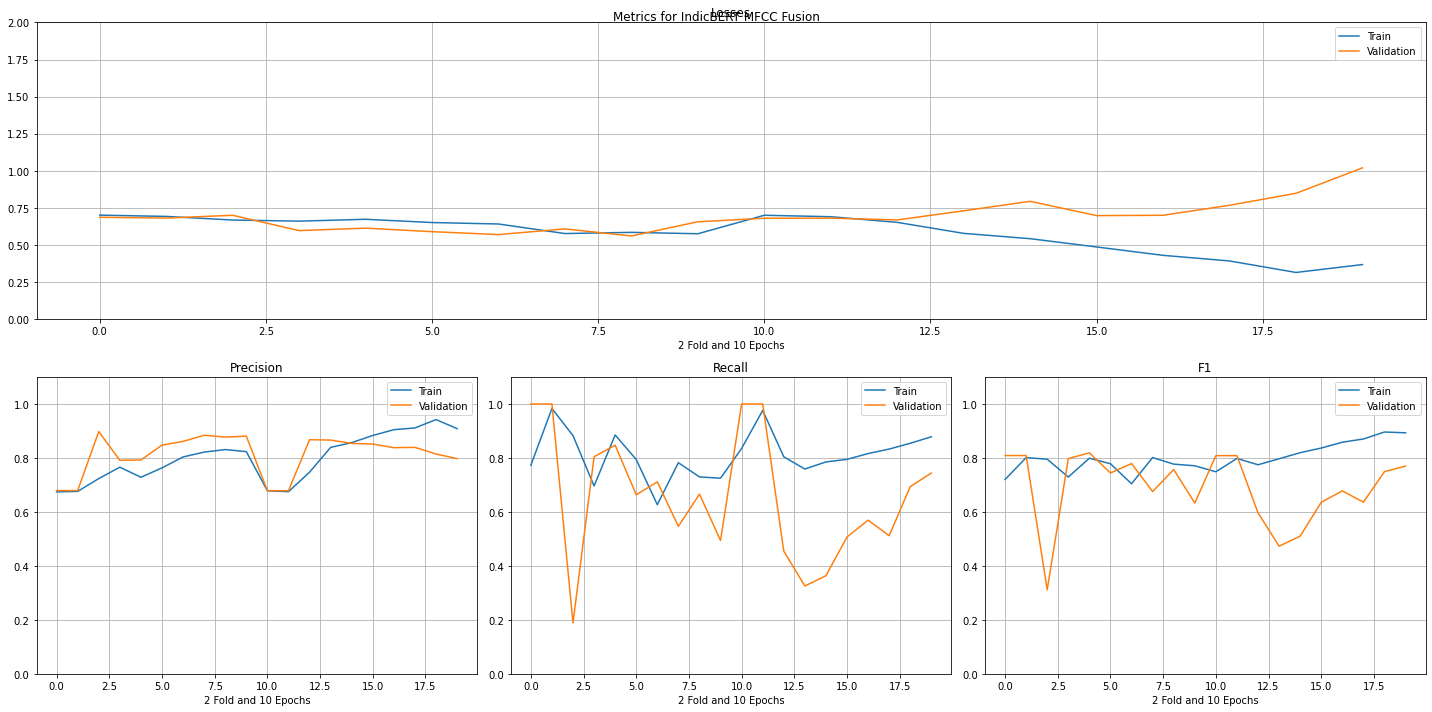

In [16]:
plot_results(mfcc_fusion_results[0], 'IndicBERT MFCC Fusion')

In [18]:
mfcc_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_precision,train_recall,train_f1,validation_precision,validation_recall,validation_f1,train_losses,validation_losses
4,0.728346,0.885167,0.799136,0.792411,0.847255,0.818916,0.673245,0.613621
1,0.675987,0.983254,0.801170,0.679092,1.000000,0.808880,0.692604,0.681581
0,0.674322,0.772727,0.720178,0.679092,1.000000,0.808880,0.701303,0.686894
1,0.674917,0.976134,0.798049,0.678571,1.000000,0.808511,0.690617,0.680736
0,0.678295,0.835322,0.748663,0.678571,1.000000,0.808511,0.700390,0.680255
3,0.765789,0.696172,0.729323,0.791080,0.804296,0.797633,0.660788,0.596894
6,0.803681,0.626794,0.704301,0.861272,0.711217,0.779085,0.641555,0.570196
9,0.908642,0.878282,0.893204,0.797436,0.744019,0.769802,0.368149,1.019811
8,0.831063,0.729665,0.777070,0.877358,0.665871,0.757123,0.585266,0.560847
8,0.942105,0.854415,0.896120,0.814607,0.693780,0.749354,0.315001,0.848287


In [19]:
mel_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MEL,
                                       k_folds=2, epochs=10, balance_classes=True, dropout_level=0.1, lr=3e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=5, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Fusion Classification
FOLD 0
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 10
Training Model


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Evaluating


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Losses - Train : 0.695 / Validation : 0.688
Time for epoch : 655.103108 seconds
Epoch 2 / 10
Training Model
Evaluating
Losses - Train : 0.692 / Validation : 0.689
Time for epoch : 48.739524 seconds
Epoch 3 / 10
Training Model
Evaluating
Losses - Train : 0.691 / Validation : 0.688
Time for epoch : 48.849374 seconds
Epoch 4 / 10
Training Model
Evaluating
Losses - Train : 0.690 / Validation : 0.682
Time for epoch : 48.851404 seconds
Epoch 5 / 10
Training Model
Evaluating
Losses - Train : 0.956 / Validation : 0.701
Time for epoch : 48.419726 seconds
Epoch 6 / 10
Training Model
Evaluating
Losses - Train : 0.695 / Validation : 0.689
Time for epoch : 48.447039 seconds
Epoch 7 / 10
Training Model
Evaluating
Losses - Train : 0.689 / Validation : 0.659
Time for epoch : 49.457866 seconds
Epoch 8 / 10
Training Model
Evaluating
Losses - Train : 0.675 / Validation : 0.662
Time for epoch : 48.908339 seconds
Epoch 9 / 10
Training Model
Evaluating
Losses - Train : 0.669 / Validation : 0.661
Time for ep

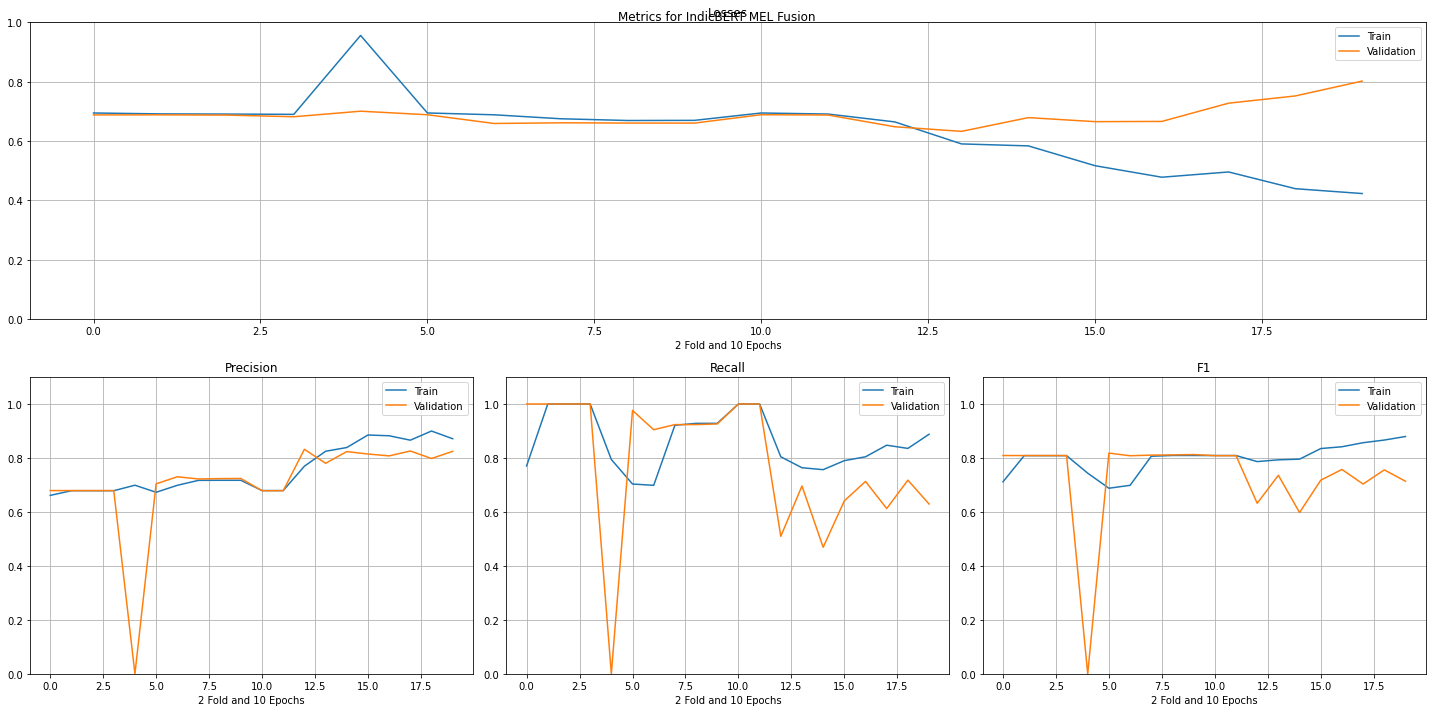

In [20]:
plot_results(mel_fusion_results[0], 'IndicBERT MEL Fusion')

In [21]:
mel_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_precision,train_recall,train_f1,validation_precision,validation_recall,validation_f1,train_losses,validation_losses
5,0.672769,0.703349,0.687719,0.703959,0.976134,0.818000,0.694873,0.688902
9,0.717190,0.928230,0.809176,0.723881,0.926014,0.812565,0.669952,0.660708
8,0.717190,0.928230,0.809176,0.723364,0.923628,0.811321,0.669484,0.660823
7,0.716946,0.921053,0.806283,0.722015,0.923628,0.810471,0.675311,0.661714
2,0.678571,1.000000,0.808511,0.679092,1.000000,0.808880,0.691132,0.687635
3,0.678571,1.000000,0.808511,0.679092,1.000000,0.808880,0.690196,0.682133
1,0.678571,1.000000,0.808511,0.679092,1.000000,0.808880,0.691751,0.688583
0,0.661191,0.770335,0.711602,0.679092,1.000000,0.808880,0.694773,0.688341
1,0.679092,1.000000,0.808880,0.678571,1.000000,0.808511,0.691232,0.687956
0,0.679092,1.000000,0.808880,0.678571,1.000000,0.808511,0.694777,0.689008
